<a href="https://colab.research.google.com/github/rouzbehshi/Model/blob/main/Input%20Data/Climate_Scenario_Generation_rev4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

This notebook generates scenarios with Monte Carlo simulation. The processes are based on the paper titled **"An efficient scenario-based stochastic programming framework for multi-objective optimal micro-grid operation"** by Taher Niknam et al.
http://dx.doi.org/10.1016/j.apenergy.2012.04.017

In [27]:
import numpy as np
from scipy.stats import norm
import pandas as pd
import pytz
from datetime import datetime
import io
import matplotlib.pyplot as plt

This module generates **$N_s$** number of scenarios based on the mean and standard deviation of values of each day in all the years in the dataset. In our dataset, we have 11 years of solar irradiance $[W/m^2]$ for each day of September from 2020 to 2030 in **Lompoc**.

# Importing Datasets

In [28]:
# Data
#Solar irradiance for each day of September in Lompoc from 2020 to 2030, CNRM 4.5

CNRM_45 = [[386.64304, 379.32132 ,369.5039 ,369.49854 ,349.77945 ,353.50824 ,357.92468 ,355.87326 ,339.0643 ,337.5132 ,315.63382 ,310.1702 ,335.4378 ,328.5307 ,335.41058 ,348.26877 ,328.613 ,315.7925 ,269.79987 ,302.5629 ,303.9438 ,306.72525 ,310.9789 ,322.0946 ,119.63811 ,19.635822 ,299.41812 ,325.6141 ,326.28232 ,236.19925],
        [391.55145, 382.79153 ,359.4783 ,292.3668 ,341.85037 ,365.12073 ,363.94083 ,363.12955 ,358.62576 ,347.96436 ,339.60144 ,344.3253 ,346.5313 ,339.74713 ,332.076 ,317.92856 ,303.67145 ,314.41754 ,303.68683 ,290.01294 ,299.55875 ,316.49408 ,305.2024 ,316.59634 ,277.76254 ,304.50928 ,322.38434 ,316.87244 ,324.34702 ,308.50174],
        [388.5114, 383.8266 ,365.79333 ,321.7617 ,365.71616 ,368.88763 ,82.66281 ,334.58533 ,331.5225 ,128.76775 ,337.32068 ,350.13474 ,317.50867 ,283.3288 ,280.72232 ,265.82758 ,320.40103 ,97.388504 ,300.3057 ,295.33325 ,252.42015 ,329.57812 ,301.2402 ,332.38657 ,332.5257 ,250.64322 ,107.19272 ,83.45659 ,124.79786 ,292.444],
        [394.98438, 339.86746 ,294.98804 ,349.80194 ,362.0565 ,359.9723 ,381.7434 ,349.78696 ,281.03418 ,311.14282 ,304.9005 ,183.90245 ,340.44073 ,314.83295 ,327.99826 ,334.59082 ,331.95343 ,366.17108 ,353.9264 ,327.42004 ,341.6188 ,102.47281 ,294.78317 ,317.19293 ,332.54956 ,316.4743 ,324.77884 ,310.22577 ,300.9496 ,302.2927],
        [390.69543, 372.3025 ,380.9222 ,366.97742 ,357.06665 ,352.19217 ,346.2419 ,352.3642 ,346.64575 ,339.79147 ,339.43576 ,307.28714 ,318.75067 ,322.63925 ,337.01822 ,351.62387 ,352.3906 ,346.35416 ,344.5362 ,344.49472 ,308.03894 ,365.57684 ,342.87546 ,288.3232 ,320.1839 ,311.85498 ,311.15463 ,328.9415 ,338.66757 ,310.59415],
        [372.3882, 375.61398 ,373.87085 ,375.22037 ,304.9899 ,286.78525 ,357.26596 ,365.5063 ,349.69498 ,354.8632 ,306.02963 ,297.00552 ,325.28806 ,330.76468 ,318.2039 ,299.5461 ,317.1652 ,295.6165 ,313.9646 ,333.14282 ,333.8817 ,326.97174 ,324.94604 ,291.55917 ,282.56036 ,275.2553 ,308.55283 ,317.18964 ,72.95709 ,296.62286],
        [386.53024, 379.08722 ,379.4702 ,366.17422 ,349.7438 ,352.89035 ,316.43552 ,360.7107 ,351.851 ,336.9841 ,259.79785 ,295.92914 ,309.83536 ,322.5281 ,289.3796 ,336.0029 ,303.025 ,291.1407 ,216.46815 ,318.41693 ,309.52118 ,297.94232 ,301.2197 ,319.81436 ,327.84094 ,337.52936 ,343.01016 ,317.08533 ,297.91138 ,299.2177],
        [381.37842, 354.20477 ,372.74066 ,357.71057 ,345.1487 ,362.95267 ,365.0495 ,330.18195 ,346.65204 ,358.31653 ,357.9928 ,350.42676 ,339.81155 ,335.50528 ,335.46802 ,340.01984 ,344.33667 ,331.6485 ,336.38306 ,338.8065 ,149.92418 ,85.42273 ,302.4317 ,118.23975 ,234.34717 ,310.62207 ,309.1067 ,320.44824 ,324.7562 ,315.749],
        [385.9495, 386.31653 ,383.9923 ,368.2118 ,359.32425 ,353.6757 ,360.20084 ,357.5157 ,360.01895 ,346.1608 ,328.57178 ,342.3854 ,366.53238 ,358.2975 ,332.1757 ,308.2923 ,310.9994 ,345.74258 ,343.62167 ,320.5168 ,350.8776 ,358.55405 ,340.6479 ,343.84824 ,355.8714 ,337.52878 ,227.07166 ,162.97003 ,196.03044 ,311.19638],
        [368.48056, 344.9039 ,340.4345 ,361.6473 ,370.15906 ,356.85532 ,348.53992 ,350.57773 ,351.5316 ,348.5134 ,348.7462 ,342.30127 ,323.06104 ,333.75467 ,335.26602 ,356.77124 ,339.71622 ,308.52866 ,312.21634 ,317.1139 ,320.80966 ,324.17554 ,320.8694 ,317.28992 ,246.76422 ,281.95688 ,199.73337 ,129.45285 ,211.19559 ,231.65318],
        [367.5223, 364.00708 ,333.872 ,341.4688 ,354.79025 ,357.82285 ,357.20212 ,363.8367 ,362.27286 ,335.7247 ,315.53772 ,338.3366 ,214.32758 ,284.5442 ,326.90652 ,214.19583 ,314.10602 ,342.74066 ,191.8743 ,261.79694 ,334.54922 ,336.4772 ,322.126 ,206.5052 ,276.98117 ,298.11258 ,313.77118 ,301.3587 ,296.15244 ,316.56476]]

The electricity generation of PV panels is a function of ambient temperature, and the solar irradiance received per each unit of area. As a result, the daily average ambient temperature data is obtained from the same climate model (CNRM 4.5).

In [29]:
#@title
url2 = 'https://raw.githubusercontent.com/rouzbehshi/Model/main/Input%20Data/tavg_day_ens32_rcp45_lompoc.csv'
t_avg = pd.read_csv(url2)

In [30]:
#@title
url1 = 'https://raw.githubusercontent.com/rouzbehshi/Model/main/Input%20Data/solarirrad_hour_cnrm_rcp45_lompoc.csv'
solar_irrad_hourly = pd.read_csv(url1)

# Functions

***(Note: The process has been done for 30 days, but depending on the temporal resolution of the study, it can be done for desired number of days.)***

The scenario generation module utilizes Monte Carlo simulation. In this regard, the normal distribution of each day is calculated based on the mean ($m$) and stdev ($δ$) of each day's values in 11 years (e.g., $m(day1)=mean(G_{day1,2020}, G_{day1,2021},..., G_{day1,2030}$). 

In the next step, the normal distribution functions are obtained for all days. Then these functions are divided into three segments ($l$), each by a $δ$ distance ($l_1=m-δ, l_2=m, l_3=m+δ$).

**Note: Depending on the desired level of precisness, the number of segments can be increased.**

<img src='https://raw.githubusercontent.com/rouzbehshi/Model/main/Input%20Data/Fig1.jpg'>

In the next step, the cumulated probability of segments is normalized in a way in which their summation becomes equal to 1 ($𝒫_{l_1}+𝒫_{l_2}+𝒫_{l_3} =1 $).

<img src='https://raw.githubusercontent.com/rouzbehshi/Model/main/Input%20Data/Fig2.jpg'>


Then a random number is generated for each day. The segment with a probability less or equal to the random number is selected as the value of that day, and the corresponding probability is the probability of that segment.

This process has been done for all 30 days, and the probability of that scenario is calculated as the product of the probability of all days.


In the last step, the probability of all scenarios is normalized as follows:

$𝒫̄$$_{s_i}=𝒫_{s_i}/∑_{1}^{N_s}𝒫_{i}$





In [31]:
def generate_solar_irradiance_scenarios(dataset, N):
    # Mean and standard deviation of each day
    mean = [np.mean([dataset[i][j] for i in range(len(dataset))]) for j in range(30)]
    stdev = [np.std([dataset[i][j] for i in range(len(dataset))]) for j in range(30)]

    # Normal distribution probability of each segment
    segment1 = [norm.pdf(mean[i], loc=mean[i], scale=stdev[i]) for i in range(30)]
    segment2 = [norm.pdf(mean[i]+stdev[i], loc=mean[i], scale=stdev[i]) for i in range(30)]
    segment3 = [norm.pdf(mean[i]-stdev[i], loc=mean[i], scale=stdev[i]) for i in range(30)]

    # Normalize the probability values
    prob_norm1 = [segment1[i]/(segment1[i]+segment2[i]+segment3[i]) for i in range(30)]
    prob_norm2 = [segment2[i]/(segment1[i]+segment2[i]+segment3[i]) for i in range(30)]
    prob_norm3 = [segment3[i]/(segment1[i]+segment2[i]+segment3[i]) for i in range(30)]

    # Accumulated normalized probability
    prob_acc1 = [prob_norm1[i] for i in range(30)]
    prob_acc2 = [prob_norm1[i]+prob_norm2[i] for i in range(30)]
    prob_acc3 = [prob_norm1[i]+prob_norm2[i]+prob_norm3[i] for i in range(30)]

    # Scenario probability
    scenario_prob = []
    day_values = []
    for i in range(N):
        scenario = []
        day_prob = 1
        for j in range(30):
            rand = np.random.uniform(0,1)
            # rand=abs(np.random.randn())
            if rand <= prob_acc1[j]:
                scenario.append(mean[j]-stdev[j])
                day_prob *= prob_norm1[j]
            elif rand <= prob_acc2[j]:
                scenario.append(mean[j])
                day_prob *= prob_norm2[j]
            else:
                scenario.append(mean[j]+stdev[j])
                day_prob *= prob_norm3[j]
        scenario_prob.append(day_prob)
        day_values.append(scenario)

    # Normalized scenario probability
    scenario_prob_norm = [scenario_prob[i]/sum(scenario_prob) for i in range(N)]

    return day_values, scenario_prob_norm


In [32]:
def plot_data_and_scenarios(dataset, day_values, scenario_prob_norm):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))

    # plot the input data
    for i in range(len(dataset)):
        ax1.plot(dataset[i], label='Year '+str(i+2020))
    ax1.legend(loc='best')
    ax1.set_title('Input Data')

    N = len(day_values)

    # Plot each scenario
    for i in range(N):
        ax2.plot(day_values[i], label='Scenario ' + str(i+1) + ' (Prob: {:.0%})'.format(scenario_prob_norm[i]))

    # Add legend
    plt.legend()
    ax2.set_title('Generated scenarios')
    # Show plot
    plt.show()


The value of solar irradiance each day is the average of daily irradiance each day. As a result, the values must multiply by the number of daylight duration to have the sum of solar irradiance each day. The average daylight duration in California during September is **12.5** hours of daylight per day.


In [33]:
# Multiply each generated value by 12.5 and store in a new variable
def daily_average_to_daily_sum(day_values,sunlight_hour):
  solar_capacity = [[day_value[i]*sunlight_hour for i in range(30)] for day_value in day_values]
  return solar_capacity

t_avg dataset must be preprocessed in advance. As a result, the data for September and the year 2015 is filtered. In the next step, the results are sorted and reindexed.

In [34]:
def t_avg_preprocessing(t_avg, year, month):
    t_avg = pd.DataFrame(t_avg)
    t_avg['time'] = pd.to_datetime(t_avg['time'])
    t_avg_year = t_avg[t_avg['time'].dt.year == year]
    month_t_avg = t_avg_year[t_avg_year['time'].dt.month == month]
    month_t_avg = month_t_avg.sort_values(by='time')
    month_t_avg = month_t_avg.reset_index(drop=True)
    daily_t_avg = month_t_avg['Avg_temp']
    return daily_t_avg

The electricity generation of a PV panel is calculated for a 100 [$W_{nominal}$] PV panel as follows:

$P_{PV}(t) = P_{STC}*n*E_m(t)/E_{STC}*[1+k*(T_m(t)-T_{STC})] $

Where:



1.   $P_{PV}(t)$ is the power output of PV
2.   $P_{STC}$ is the maximum power output of PV in the standard test condition
3.   $E_m(t)$ is the solar irradiance at time t $[W/m^2]$
4.   $E_{STC}$ is the solar irradiance in standard test condition (= 1000 $[kW/m^2]$)
5.   $n$ is the number of PV panels
6.   $k$ is the temperature coefficient (= -0.0049 [1/°C])
7.   $T_{STC}$ is the temperature of PV in standard test condition (= 25°C)
8.   $T_m(t)$ is the PV temperature and is calculated as follows:


$T_m(t)=T_{amb}(t)+ℇ_{PV}*E_m(t)/E_{STC}$

$T_{amb}(t)=(T_{max}(t)+T_{min}(t))/2$

Where:

1.   $T_{amb}$ is the ambient temperature
2.   $ℇ_{PV}$ is the constant given by manufacturer (= 30)

Here by considering one 100 $W_{nominal}$ PV panel, the results show the capacity factor of PV each in each time step (in percent).


$Capacity Factor (t,s)=100*Solar Irradiance (t,s)/1000*(1-0.0049*(T_{amb}(t)+Solar Irradiance (t,s)/1000*30-25°C))$

In [35]:
def pv_generation(CNRM_45_daily_irrad_scenario, CNRM_45_daily_t_avg, N):
    pv_generation = [[100 * CNRM_45_daily_irrad_scenario[i][j] / 1000 * (1 - 0.0049 * (CNRM_45_daily_t_avg[j] + CNRM_45_daily_irrad_scenario[i][j] / 1000 * 30 - 25)) for j in range(30)] for i in range(N)]
    return pv_generation


In the next part, the daily solar irradiation scenarios are used to model the hourly electricity generation of a **100 W** PV panel.

The input data is hourly solar irradiance in Lompoc in 2015. 

First, The data for September is filtered. The next step calculates the relative solar irradiance of each day **(norm_gi)**. This process is done with the assumption that the sun's position in each day and month is the same in all years and only the intensity of solar irradiance will change. 

In [36]:
def normalize_solar_irradiance(month, solar_irrad_hourly):
    solar_irrad_hourly = pd.DataFrame(solar_irrad_hourly)
    solar_irrad_hourly['time'] = pd.to_datetime(solar_irrad_hourly['time'])
    september_solar_irrad_hourly = solar_irrad_hourly[solar_irrad_hourly['time'].dt.month == month]
    september_solar_irrad_hourly.loc[:, 'day'] = september_solar_irrad_hourly['time'].dt.date
    sum_gi = september_solar_irrad_hourly.groupby('day')['G(i)'].transform('sum')
    september_solar_irrad_hourly.loc[:, 'norm_gi'] = september_solar_irrad_hourly['G(i)'] / sum_gi
    september_solar_irrad_hourly = september_solar_irrad_hourly.sort_values(by='time')
    september_solar_irrad_hourly = september_solar_irrad_hourly.reset_index(drop=True)
    return september_solar_irrad_hourly

The obtained values are daily. By using these values and hourly coefficients, they are transformed into hourly values.

In [37]:
# The coefficient dataset is named 'september_solar_irrad_data'
# The column containing coefficients is named 'norm_gi'
def daily_to_hourly_generation(daily_pv_generation, solar_irrad_hourly_coeff, N):
    capacity_factor_hourly = [[daily_pv_generation[i][j] * solar_irrad_hourly_coeff.loc[k, 'norm_gi'] 
                               for k in range(j*24,(j+1)*24)] 
                              for i in range(N) for j in range(30)]
    return capacity_factor_hourly

In [38]:
def supply_format(hourly_pv_generation, N, start_day, end_day):
    D = end_day - start_day
    df4 = []
    extract = []
    for i in range(N):
        first_day = i * 30
        last_day = (i + 1) * 30
        extract.append(hourly_pv_generation.iloc[first_day + start_day : first_day + end_day, :])

    df_list = []
    for sub_list in extract:
        df = pd.DataFrame(sub_list)
        df_list.append(df)
    extracted_hourly_pv_generation = pd.concat(df_list)

    extracted_hourly_pv_generation = extracted_hourly_pv_generation.reset_index()
    extracted_hourly_pv_generation = extracted_hourly_pv_generation.T
    extracted_hourly_pv_generation = extracted_hourly_pv_generation.iloc[1:, :]

    for i in range(0, N * D, D):
        cols = [extracted_hourly_pv_generation.iloc[:, j] for j in range(i, i + D)]
        df3 = pd.concat(cols, axis=0)
        df4.append(df3)

    extracted_capacity_factor_hourly_for_model = pd.DataFrame()
    for i in [*range(len(df4))]:
        extracted_capacity_factor_hourly_for_model[i] = df4[i]
    extracted_capacity_factor_hourly_for_model = extracted_capacity_factor_hourly_for_model.reset_index()
    extracted_capacity_factor_hourly_for_model = extracted_capacity_factor_hourly_for_model.iloc[:, 1:]

    data = extracted_capacity_factor_hourly_for_model.to_dict(orient='index')
    pv_generation_hourly = {i: {j + 1: data[i][j] for j in data[i]} for i in data}
    return pv_generation_hourly

In [39]:
def plot_capacity_factor(capacity_factor_hourly, start, end, N):
    fig, axs = plt.subplots(N, 1, figsize=(10, 14))

    for i, ax in enumerate(axs.flatten()):
        start_row = i * 30
        end_row = (i + 1) * 30
        for j in range(start_row + start-1, start_row + end-1):
            ax.plot(capacity_factor_hourly.columns, capacity_factor_hourly.iloc[j,:], label='Day ' + str(j + 1 - start_row)+' (prob = '+str(round(CNRM_45_daily_irrad_prob_norm[i],2)))
        ax.set_title("Capacity factor from Day "+str(start)+ " to Day "+str(end-1)+ " in Scenario " + str(i + 1))
        ax.legend()
    fig.subplots_adjust(wspace=0.5, hspace=1)
    plt.tight_layout()

# Initializing

In [40]:
year = 2015
month = 9
start_day = 7 #The first day 
end_day = 9 #The last day
sunlight_hour = 12.5
N = 7 # Number of scenarios

# Outputs
**Note**: The sum of probabilities in the plot might become more than 1. This is due to the fact that the values are rounded.

In [41]:
CNRM_45_daily_irrad_scenario, CNRM_45_daily_irrad_prob_norm = generate_solar_irradiance_scenarios(CNRM_45,N)

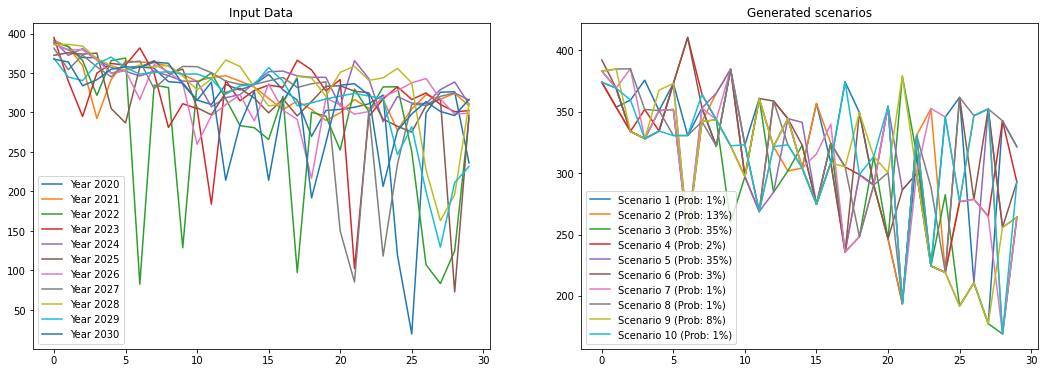

In [42]:
plot_data_and_scenarios(CNRM_45 , CNRM_45_daily_irrad_scenario , CNRM_45_daily_irrad_prob_norm)

In [43]:
CNRM_45_daily_irrad_scenario = daily_average_to_daily_sum(CNRM_45_daily_irrad_scenario, sunlight_hour)

In [44]:
CNRM_45_daily_t_avg = t_avg_preprocessing(t_avg, year, month)

In [45]:
daily_pv_generation = pv_generation(CNRM_45_daily_irrad_scenario, CNRM_45_daily_t_avg, N)

In [46]:
solar_irrad_hourly_coeff = normalize_solar_irradiance(month, solar_irrad_hourly)

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [47]:
hourly_pv_generation = daily_to_hourly_generation (daily_pv_generation , solar_irrad_hourly_coeff , N)

In [48]:
hourly_pv_generation=pd.DataFrame(hourly_pv_generation)

In [49]:
CNRM_45_hourly_scenario = supply_format(hourly_pv_generation, N, start_day, end_day)

Transforming data to daily scenarios to input it into the model

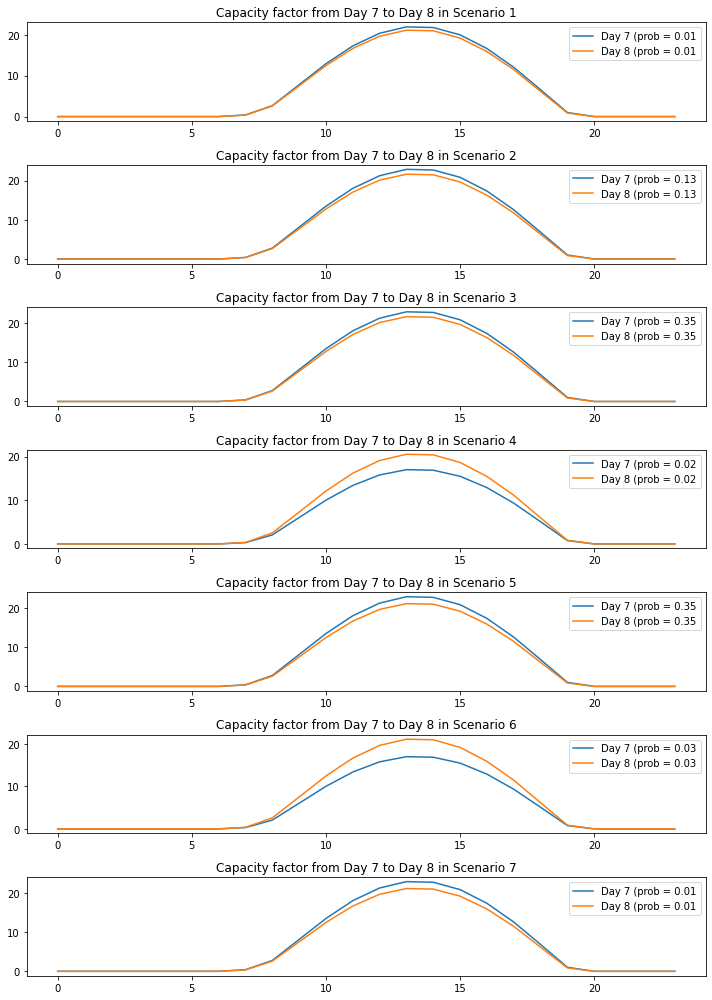

In [50]:
plot_capacity_factor(hourly_pv_generation , start_day , end_day , N)